In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import io
import torch.nn as nn
import os
import pandas as pd
import cv2
from utils import *
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torchvision import transforms
import gc
# from torchvision.transforms import v2

# Data

In [2]:
folder_path_train = "video_data/train/"
folder_path_test = "video_data/test/"

In [3]:
train_df = pd.read_csv("video_data/train.csv")
test_df = pd.read_csv("video_data/test.csv")

In [4]:
train_df['tag'].value_counts()

tag
Punch           121
PlayingCello    120
CricketShot     118
ShavingBeard    118
TennisSwing     117
Name: count, dtype: int64

In [5]:
test_df['tag'].value_counts()

tag
CricketShot     49
TennisSwing     49
PlayingCello    44
ShavingBeard    43
Punch           39
Name: count, dtype: int64

## Init data

## Encode label

In [6]:
label_encoder = LabelEncoder()

## Make dataframe metadata

In [7]:
def make_train_dataframe_metadata(df):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_punch[:80], df_playCello[:80], df_CricketShot[:80], df_ShavingBeard[:80], df_TennisSwing[:80]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    new_df['tag'] = label_encoder.fit_transform(new_df['tag'])
    new_df
    return new_df

In [8]:
df_train = make_train_dataframe_metadata(train_df)
df_train

,video_name,tag,origin_tag
0,v_Punch_g08_c01.avi,2,Punch
1,v_Punch_g08_c02.avi,2,Punch
2,v_Punch_g08_c03.avi,2,Punch
3,v_Punch_g08_c04.avi,2,Punch
4,v_Punch_g08_c05.avi,2,Punch
...,...,...,...
395,v_TennisSwing_g19_c01.avi,4,TennisSwing
396,v_TennisSwing_g19_c02.avi,4,TennisSwing
397,v_TennisSwing_g19_c03.avi,4,TennisSwing
398,v_TennisSwing_g19_c04.avi,4,TennisSwing


In [9]:
decode_label = dict()
for index, row in df_train.iterrows():
    decode_label.update({row['tag']: row['origin_tag']})

In [10]:
encode_label = {v:k for k,v in decode_label.items()}

In [11]:
def make_val_dataframe_metadata(df):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_punch[80:101], df_playCello[80:101], df_CricketShot[80:101], df_ShavingBeard[80:101], df_TennisSwing[80:101]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    new_df['tag'] = new_df['tag'].map(encode_label)
    new_df
    return new_df

In [12]:
df_val = make_val_dataframe_metadata(train_df)
df_val

,video_name,tag,origin_tag
0,v_Punch_g19_c06.avi,2,Punch
1,v_Punch_g19_c07.avi,2,Punch
2,v_Punch_g20_c01.avi,2,Punch
3,v_Punch_g20_c02.avi,2,Punch
4,v_Punch_g20_c03.avi,2,Punch
...,...,...,...
100,v_TennisSwing_g22_c04.avi,4,TennisSwing
101,v_TennisSwing_g22_c05.avi,4,TennisSwing
102,v_TennisSwing_g22_c06.avi,4,TennisSwing
103,v_TennisSwing_g23_c01.avi,4,TennisSwing


In [13]:
def make_test_dataframe_metadata(df):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_CricketShot[:100], df_TennisSwing[:100], df_playCello[:100], df_ShavingBeard[:100], df_punch[:100]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    new_df['tag'] = new_df['tag'].map(encode_label)
    return new_df

In [14]:
df_test = make_test_dataframe_metadata(test_df)
df_test

,video_name,tag,origin_tag
0,v_CricketShot_g01_c01.avi,0,CricketShot
1,v_CricketShot_g01_c02.avi,0,CricketShot
2,v_CricketShot_g01_c03.avi,0,CricketShot
3,v_CricketShot_g01_c04.avi,0,CricketShot
4,v_CricketShot_g01_c05.avi,0,CricketShot
...,...,...,...
219,v_Punch_g07_c03.avi,2,Punch
220,v_Punch_g07_c04.avi,2,Punch
221,v_Punch_g07_c05.avi,2,Punch
222,v_Punch_g07_c06.avi,2,Punch


## check load video

In [15]:
video_train_paths = [os.path.join(folder_path_train, i) for i in df_train['video_name']]
video_test_paths = [os.path.join(folder_path_test, i) for i in df_test['video_name']]
video_val_paths = [os.path.join(folder_path_train, i) for i in df_val['video_name']]

- Đầu ra của hàm load_video là list của các frame trong cùng 1 video , chiều của 1 frame: channel, height, width : channel, imgsize, imgsize: 3, 224,224

In [16]:
load_video(video_train_paths[100])[0].shape # channel, height, width

torch.Size([3, 480, 480])

In [17]:
load_video(video_test_paths[100])[0].shape

torch.Size([3, 480, 480])

In [18]:
load_video(video_val_paths[100])[0].shape

torch.Size([3, 480, 480])

100


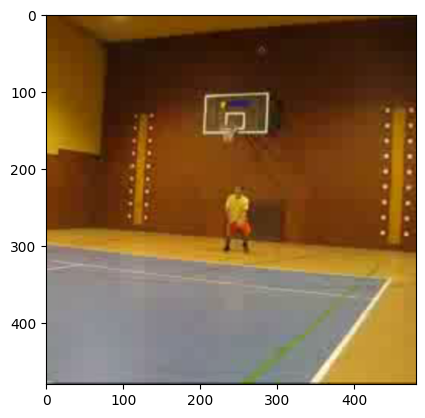

In [19]:
vid0_frame = load_video(video_val_paths[100])
print(len(vid0_frame))
img_plot_test = vid0_frame[0].permute(1,2,0).numpy() # chuyển về height, width, channel để plot ảnh (224,224,3)
plt.imshow(img_plot_test)

## Make data object

### Augmentation for data

In [20]:
def augmentation_picture(frame):
    transform_a_frame = transforms.Compose([
        transforms.RandomRotation(degrees=(90,90)), # xoay ảnh 90 90
        transforms.GaussianBlur(kernel_size=11, sigma=1), # làm mờ ảnh nhẹ với vùng ảnh là 11x11
        transforms.RandomErasing(scale=(0.01, 0.1), ratio=(1, 1)) # scale là phạm vi tỷ lệ (min, max) cho vùng xóa so với ảnh ban đầu, ratio là tỉ lệ chiều rộng và cao
    ])
    result = transform_a_frame(frame)
    return result
    

In [21]:
def augmentation_video(frames):
    new_frames = []
    for frame in frames:
        new_frame = augmentation_picture(frame)
        new_frames.append(new_frame)
    return torch.stack(new_frames,dim=0)

### Test augment method

In [22]:
test_augment_path = video_train_paths[20]
frames_before = load_video(test_augment_path, size=(120,120))
frames_after = augmentation_video(frames_before)

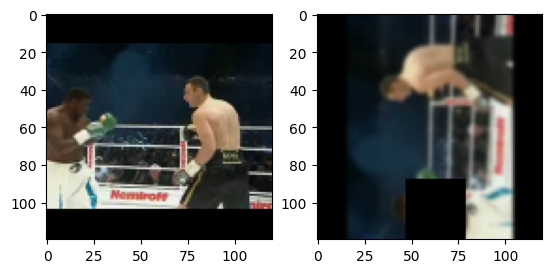

In [23]:
img_after_augment = frames_after[0].permute(1,2,0).numpy()
img_before_augment = frames_before[0].permute(1,2,0).numpy()
fig_aug, ax_aug = plt.subplots(1,2)
ax_aug[0].imshow(img_before_augment)
ax_aug[1].imshow(img_after_augment)

In [24]:
class Video_data(Dataset):
    def __init__(self, video_paths, imgsize = (120,120), all_label = [], train=True):
        self.video_paths = video_paths
        self.imgsize = imgsize
        self.labels = all_label
        self.all_label = []
        self.train = train
        self.data = self.get_data(self.video_paths, self.imgsize)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.all_label[index]
    def get_data(self, video_paths, imgsize):
        all_data = []
        for index in range(len(video_paths)):
            path = video_paths[index]
            label = self.labels[index]
            frames = load_video(path=path, size=imgsize) # dim = (100, 3, imgsize[0], imgsize[1])
            
            #add frames
            self.all_label.append(label)
            all_data.append(frames)
            if self.train:
                #add frames_augment
                frames_augment = augmentation_video(frames)
                all_data.append(frames_augment)
                self.all_label.append(label)

        return pad_sequence(all_data, batch_first=True, padding_value=0)


In [25]:
all_label_train = list(df_train['tag'])

In [26]:
all_label_val = list(df_val['tag'])

- cell dưới chạy lâu và tốn ram

In [27]:
train_dataset = Video_data(video_train_paths, all_label= all_label_train)

In [28]:
val_dataset = Video_data(video_val_paths, all_label=all_label_val)

In [29]:
test_dataset = Video_data(video_test_paths, all_label=list(df_test['tag']), train=False)

- visualize kết quả

CricketShot


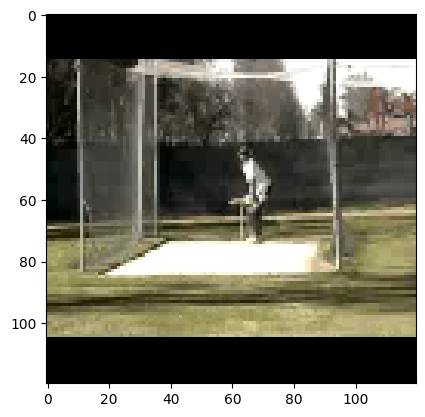

In [30]:
frames, label = val_dataset.__getitem__(100)
print(decode_label[label])
plt.imshow(frames[0].permute(1,2,0).numpy())

## Dataloader

In [31]:
dataloader_train = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [32]:
dataloader_val = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [33]:
dataloader_test = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model

## CNN feature extraction

In [34]:
CNN_pretrained = torchvision.models.resnet50(pretrained = True)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
list(CNN_pretrained.children())[7]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [36]:
CNN_pretrained = torch.nn.Sequential(*list(CNN_pretrained.children())[:8])

### A sample dataloader

In [37]:
sample_frames, sample_label = next(iter(dataloader_val))
print(decode_label[int(sample_label[0])])
sample_frames.shape

Punch


torch.Size([4, 100, 3, 120, 120])

In [38]:
output_test = CNN_pretrained(sample_frames[:,1].float())

In [39]:
output_test.shape

torch.Size([4, 2048, 4, 4])

- vì đầu ra của 1 ảnh sau khi đưa qua CNN feature extractor có số chiều là batch x channel x height x width nên cần được flatten ra theo từng batch thành vector để làm input của RNN

## CNN-RNN model

torch.nn.RNN has two inputs - input and h_0 ie. the input sequence and the hidden-layer at t=0. If we don't initialize the hidden layer, it will be auto-initiliased by PyTorch to be all zeros.

- input is the sequence which is fed into the network. It should be of size (seq_len, batch, input_size). If batch_first=True, the input size is (batch, seq_len, input_size).

- h_0 is the initial hidden state of the network. It is of the size (num_layers * num_directions, batch, input_size) where num_layers is the number of stacked RNNs. num_directions = 2 for bidirectional RNNs and 1 otherwise.

torch.nn.RNN has two outputs - out and hidden.

- out is the output of the RNN from all timesteps from the last RNN layer. It is of the size (seq_len, batch, num_directions * hidden_size). If batch_first=True, the output size is (batch, seq_len, num_directions * hidden_size).

- h_n is the hidden value from the last time-step of all RNN layers. It is of the size (num_layers * num_directions, batch, hidden_size). h_n is unaffected by batch_first=True

In [40]:
class LSTM_model(nn.Module):
    def __init__(self, CNN_pretrained, hidden_size, num_classes, batch_size):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.cnn = CNN_pretrained
        self.lstm1 = nn.LSTM(input_size = (2048*4*4), hidden_size = hidden_size, batch_first=True, num_layers=2)
        '''Làm việc với batch thì phải để batch_first = True để đảm bảo số chiều đầu ra đúng
        input_size là chiều của một phần tử trong batch, hidden_size là chiều của vector st (st được tính toán dựa trên s(t-1) trước đó
        và xt hiện tại). với batch_size = 2 thì chiều của st sẽ là (batch_size, hidden_size). Mỗi bước thời gian tương ứng với từng frame
        của ảnh sẽ tạo thành chuỗi thời gian cho mạng'''
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.batch_size = batch_size
    def forward(self, batch_frames_of_a_vid):
        # frame: #batch_size x frame x channel x height x width
        # đang để batch size nên mới làm như thế này, duyệt qua từng frame của từng video trong batch
        input = list()
        for ind in range(batch_frames_of_a_vid.size(1)):
            hidden = torch.zeros((self.batch_size, self.hidden_size)) # khởi tạo hidden
            frame = batch_frames_of_a_vid[:, ind] 
            '''Lấy đồng thời từng frame của từng video trong batch, vị trí đầu để dấu : là tất cả các vid,
            vị trí thứ 2 là để ind tức là frame thứ ind của các video'''
            frame = frame.float()
            with torch.no_grad():
                x = self.cnn(frame)
                x = x.view(x.size(0), 2048*4*4) # flatten dữ liệu của từng mẫu trong batch, để x.size(0) để tránh trường hợp dữ liệu bị lẻ không có batch
            input.append(x) # append một batch gồm batch_size frame đã được flatten vào input list
        input = torch.stack(input, dim=1) # shape của input: (batch_size, total_frame_of_1 vid, 2048*4*4)
        '''stack list của các batch_tensor thành 1 tensor để đưa vào RNN
        .Ở đây để dim=1 là để stack từng frames của từng video trong 1 batch vào với nhau, và giữ được batch_size'''
        out1, hidden1 = self.lstm1(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res[0])
        return x

In [41]:
model = LSTM_model(CNN_pretrained,512, 5, 2)

In [42]:
test_output = model(sample_frames)
test_output

tensor([[-0.1815, -0.0914, -0.0938, -0.1268,  0.0173],
        [ 0.1008, -0.1802, -0.1054,  0.2226, -0.0722],
        [ 0.2156, -0.2913, -0.3607,  0.3300,  0.0385],
        [ 0.3078, -0.1349,  0.0956, -0.1262, -0.1563]],
       grad_fn=<AddmmBackward0>)

# Early stopping

In [43]:
class Early_stopping:
    def __init__(self, path_to_save, delta):
        '''
        delta là tham số kiểm soát độ dao động của loss, loss ở các epoch đầu được phép dao dộng lớn hơn loss ở các epoch về sau
        '''
        self.best_val_loss_average = np.inf
        self.path_to_save = path_to_save
        self.early_stop = False
        self.delta = delta
    
    def __call__(self, all_loss_val_current, model):
        average_loss = np.average(all_loss_val_current)
        if average_loss < self.best_val_loss_average:
            print(f"loss validation average decrease from {self.best_val_loss_average} to {average_loss}, Saving checkpoint...")
            self.best_val_loss_average = average_loss
            torch.save(model.state_dict(), self.path_to_save)
        elif average_loss < self.best_val_loss_average + self.delta*self.best_val_loss_average:
            print(f"loss validation average slightly increased from {self.best_val_loss_average} to {average_loss}, No save! ")
            pass
        else:
            self.early_stop = True

# Train

## Trainner

In [44]:
class Trainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
    def val(self, model_val, device):
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        all_loss_vall_current = []
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            out = out.to(device)
            criterion_val = self.criterion
            loss_val = criterion_val(out, b)
            all_loss_vall_current.append(loss_val.detach().numpy())
            total_correct_val += (torch.argmax(out, dim=1) == b).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            pbar_val.set_description(f'Acc_val: {acc_val} loss_val {loss_val}')
        return all_loss_vall_current
        
    def train(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device_val = torch.device("cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        early_stopping = Early_stopping("model_checkpoint.pt", delta=0.15)
        for epoch in range(self.epochs):
            
            model.train()
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            for X, y in pbar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                total_correct += (torch.argmax(yh, dim=1) == y).sum().item()
                total += y.size(0)
                acc = total_correct/total
                loss = criterion(yh, y)
                '''
                Với criterion là CrossEntropyLoss thì thứ tự là output trc rồi đến target
                    vì hàm này yêu cầu chiều của output là (batch_size x class) còn chiều của target là (batch_size)
                '''
                loss.backward()
                optimizer.step()
                pbar.set_description(f'Epoch: {epoch} Loss: {loss.item()}, Acc: {acc}')
            all_loss_val_current = self.val(model.to(device_val), device_val)
            early_stopping.delta = 0.15 * (1/(epoch+1))
            model.to(device)
            early_stopping(all_loss_val_current, model)
            if early_stopping.early_stop:
                print("early stop")
                break


In [45]:
trainer = Trainer(dataloader_train, dataloader_val, model, torch.optim.AdamW(model.parameters(), lr=0.0001), nn.CrossEntropyLoss(), epochs=100)

In [ ]:
torch.cuda.empty_cache()
trainer.train()

Epoch: 0 Loss: 0.7303757667541504, Acc: 0.64625: 100%|██████████| 200/200 [09:11<00:00,  2.76s/it]            
Acc_val: 0.6190476190476191 loss_val 0.8500446081161499: 100%|██████████| 53/53 [13:51<00:00, 15.68s/it] 


loss validation average decrease from inf to 1.050594687461853, Saving checkpoint...


Epoch: 1 Loss: 1.0608646869659424, Acc: 0.8475: 100%|██████████| 200/200 [08:58<00:00,  2.69s/it]             
Acc_val: 0.7380952380952381 loss_val 1.154069185256958: 100%|██████████| 53/53 [13:52<00:00, 15.71s/it]  


loss validation average decrease from 1.050594687461853 to 0.817114531993866, Saving checkpoint...


Epoch: 2 Loss: 0.4282933473587036, Acc: 1.0:   2%|▏         | 3/200 [00:08<08:52,  2.70s/it] 

In [ ]:
device_cpu = torch.device("cpu")
model.to(device_cpu)
device = next(model.parameters()).device
device

device(type='cpu')

# Test

## tester

In [ ]:
class Tester:
    def __init__(self, model, dataloader_test):
        self.dataloader_test = dataloader_test
        self.model = model
    def test(self):
        torch.cuda.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_test = self.model
        pbar_test = tqdm(self.dataloader_test)
        total_test = 0
        total_correct_test = 0
        for a, b in pbar_test:
            a = a.to(device)
            b = b.to(device)
            out = model_test(a)
            total_correct_test += (torch.argmax(out, dim=1) == b).sum().item()
            total_test += b.size(0)
            acc_test = total_correct_test/total_test
            pbar_test.set_description(f'Acc_test: {acc_test}')

In [ ]:
tester = Tester(model, dataloader_test)
tester.test()

Acc_test: 0.36607142857142855: 100%|██████████| 56/56 [02:21<00:00,  2.53s/it]


# Trash

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda")
out_put_after = model(sample_frames.to(device))
torch.argmax(out_put_after, dim=1)

tensor([0, 4, 3, 2], device='cuda:0')

In [ ]:
sample_label

tensor([0, 0, 3, 4])